# Machine Learning applied to MuJoCo environment – Raw angles models

* ### Author: Mowibox (Ousmane THIONGANE)
* ### Date: November 4th, 2024

## Imports

In [ ]:
import os 
import time
from utils import *
import pandas as pd
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam, SGD
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential, save_model

Here, I tried to compute a custom loss based on the Euclidian distance. Noting $\theta$ and $\phi$ respectively the actual and predicted angles, the expression of the Euclidian distance will be:

$d²_E(\theta, \phi)=(\cos\theta-\cos\phi)²+(\sin\theta-\sin\phi)²$

$d²_E(\theta, \phi)=\cos²\theta-2\cos\theta \cos\phi + \cos²\phi+\sin²\theta-2\sin\theta\sin\phi + \sin²\phi$

$d²_E(\theta, \phi)=2-2\cos(\theta-\phi)$

By using this function, we just need to provide the angles values as the model input without needing their cosines and sines. Here follows the whole process:

### I - 2D with 2 joints

##### Data processing

In [150]:
filepath_2R = r'data/2R_2184503_100.csv'
df_2R = pd.read_csv(filepath_2R, sep=";", header=0).copy()

display(df_2R.head(2))
df_2R.info()

,j0,j1,cos(j0),cos(j1),sin(j0),sin(j1),ee_x,ee_y,ee_qw,ee_qz
0,0.034,0.003,0.999,1.0,0.034,0.003,0.21,0.007,1.0,0.018
1,0.048,0.004,0.999,1.0,0.048,0.004,0.21,0.010,1.0,0.026


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 10 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   j0        100000 non-null  float64
 1    j1       100000 non-null  float64
 2    cos(j0)  100000 non-null  float64
 3    cos(j1)  100000 non-null  float64
 4    sin(j0)  100000 non-null  float64
 5    sin(j1)  100000 non-null  float64
 6    ee_x     100000 non-null  float64
 7    ee_y     100000 non-null  float64
 8    ee_qw    100000 non-null  float64
 9    ee_qz    100000 non-null  float64
dtypes: float64(10)
memory usage: 7.6 MB


In [151]:
X_2R_raw = df_2R[['j0', ' j1']].values
X_2R_raw = pd.DataFrame(X_2R_raw, columns=['j0', 'j1'])
display(X_2R_raw.head(2))

y_2R_pos = df_2R[[' ee_x', ' ee_y']].values
y_2R_ori = df_2R[[' ee_qw', ' ee_qz']].values

y_2R = pd.concat([pd.DataFrame(y_2R_pos, columns=['ee_x', 'ee_y']), 
                         pd.DataFrame(y_2R_ori, columns=['ee_qw', 'ee_qz'])], axis=1)

display(y_2R.head(2))

,j0,j1
0,0.034,0.003
1,0.048,0.004


,ee_x,ee_y,ee_qw,ee_qz
0,0.21,0.007,1.0,0.018
1,0.21,0.010,1.0,0.026


In [152]:
percentage_2R = 0.1
X_2R_train, X_2R_test, y_2R_train, y_2R_test = train_test_split(X_2R_raw, y_2R_pos, test_size=0.2, random_state=2184503)

subset_size_train = int(len(X_2R_train)*percentage_2R)
subset_size_test = int(len(X_2R_test)*percentage_2R)
X_2R_train = X_2R_train[:subset_size_train]
y_2R_train = y_2R_train[:subset_size_train]
X_2R_test = X_2R_test[:subset_size_test]
y_2R_test = y_2R_test[:subset_size_test]

print(X_2R_train.shape, y_2R_train.shape)
print(y_2R_test.shape, y_2R_test.shape)

(8000, 2) (8000, 2)
(2000, 2) (2000, 2)


##### Model

In [153]:
model_2R = Sequential()
model_2R.add(Input((X_2R_train.shape[1],)))
model_2R.add(Dense(45, activation="relu"))
model_2R.add(Dense(35, activation="relu"))
model_2R.add(Dense(25, activation="relu"))
model_2R.add(Dense(15, activation="relu"))
model_2R.add(Dense(y_2R_train.shape[1], activation="linear"))
model_2R.summary()

Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_128 (Dense)               │ (None, 45)             │           135 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_129 (Dense)               │ (None, 35)             │         1,610 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_130 (Dense)               │ (None, 25)             │           900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_131 (Dense)               │ (None, 15)             │           390 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_132 (Dense)               │ (None, 2)              │            32 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,067 (11.98 KB)

 Trainable params: 3,067 (11.98 KB)

 Non-trainable params: 0 (0.00 B)

In [154]:
epochs_2R = 20

model_2R.compile(loss=angular_loss, optimizer=Adam(learning_rate=0.001))

start = time.time()
history_2R = model_2R.fit(X_2R_train, y_2R_train,
                    epochs=epochs_2R,
                    validation_data=(X_2R_test, y_2R_test),
                    verbose=1)
training_time = time.time() - start


y_2R_train_pred = model_2R.predict(X_2R_train)
y_2R_test_pred = model_2R.predict(X_2R_test)

mae_2R_train = mean_absolute_error(y_2R_train, y_2R_train_pred)
mae_2R_test = mean_absolute_error(y_2R_test, y_2R_test_pred)

r2_2R_test = r2_score(y_2R_test, y_2R_test_pred)
r2_2R_train = r2_score(y_2R_train, y_2R_train_pred)

Epoch 1/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0054 - val_loss: 0.0013
Epoch 2/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0010 - val_loss: 3.9491e-04
Epoch 3/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.5411e-04 - val_loss: 2.0745e-04
Epoch 4/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.9146e-04 - val_loss: 1.1184e-04
Epoch 5/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1365e-04 - val_loss: 6.7387e-05
Epoch 6/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.8533e-05 - val_loss: 8.9555e-05
Epoch 7/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.3872e-05 - val_loss: 4.8855e-05
Epoch 8/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.5909e-05 - val_loss: 5.1941e-05
Epoch 9/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.7398e-05 - val_loss: 2.8427e-05
Epoch 10/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.6327e-05 - val_loss: 3.3640e-05
Epoch 11/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.3487e-05

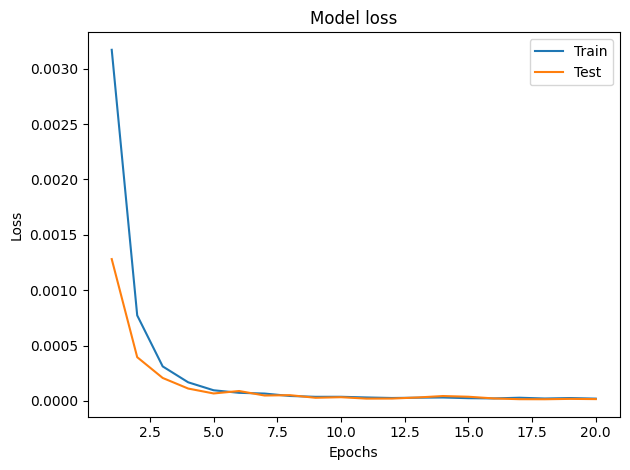

== Training Time ==
10.35 seconds

== Final loss ==
Train: 2.07398315978935e-05
Test: 1.6410678654210642e-05

== Mean absolute error ==
Train: 0.00322270640598936
Test: 0.003241654944567016

== R2 Score ==
Train: 0.9981172909145912
Test: 0.9981380909688782


In [155]:
displayLearningCurve(history=history_2R, 
                    epochs=epochs_2R)

print(f"== Training Time ==\n{training_time:.2f} seconds\n")
print(f"== Final loss ==\nTrain: {history_2R.history['loss'][-1]}\nTest: {history_2R.history['val_loss'][-1]}\n")
print(f"== Mean absolute error ==\nTrain: {mae_2R_train}\nTest: {mae_2R_test}\n")
print(f"== R2 Score ==\nTrain: {r2_2R_train}\nTest: {r2_2R_test}")

### II - 2D with 3 joints

In [156]:
filepath_3R = r'data/3R_2184503_100.csv'
df_3R = pd.read_csv(filepath_3R, sep=";", header=0).copy()

display(df_3R.head(3))
df_3R.info()

,j0,j1,j2,cos(j0),cos(j1),cos(j2),sin(j0),sin(j1),sin(j2),ee_x,ee_y,ee_qw,ee_qz
0,0.034,0.003,-0.002,0.999,1.0,1.0,0.034,0.003,-0.002,0.310,0.011,1.000,0.017
1,0.047,0.004,-0.003,0.999,1.0,1.0,0.047,0.004,-0.003,0.310,0.015,1.000,0.024
2,0.105,0.001,-0.008,0.994,1.0,1.0,0.105,0.001,-0.008,0.308,0.032,0.999,0.049


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 13 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   j0        100000 non-null  float64
 1    j1       100000 non-null  float64
 2    j2       100000 non-null  float64
 3    cos(j0)  100000 non-null  float64
 4    cos(j1)  100000 non-null  float64
 5    cos(j2)  100000 non-null  float64
 6    sin(j0)  100000 non-null  float64
 7    sin(j1)  100000 non-null  float64
 8    sin(j2)  100000 non-null  float64
 9    ee_x     100000 non-null  float64
 10   ee_y     100000 non-null  float64
 11   ee_qw    100000 non-null  float64
 12   ee_qz    100000 non-null  float64
dtypes: float64(13)
memory usage: 9.9 MB


In [157]:
X_3R_raw = df_3R[['j0', ' j1', ' j2']].values
X_3R_raw = pd.DataFrame(X_3R_raw, columns=['j0', 'j1', 'j2'])
display(X_3R_raw.head(2))

y_3R_pos = df_3R[[' ee_x', ' ee_y']].values
y_3R_ori = df_3R[[' ee_qw', ' ee_qz']].values
y_3R = pd.concat([pd.DataFrame(y_3R_pos, columns=['ee_x', 'ee_y']), 
                         pd.DataFrame(y_3R_ori, columns=['ee_qw', 'ee_qz'])], axis=1)

display(y_3R.head(2))

,j0,j1,j2
0,0.034,0.003,-0.002
1,0.047,0.004,-0.003


,ee_x,ee_y,ee_qw,ee_qz
0,0.31,0.011,1.0,0.017
1,0.31,0.015,1.0,0.024


In [158]:
X_3R_train, X_3R_test, y_3R_train, y_3R_test = train_test_split(X_3R_raw, y_3R_pos, test_size=0.2, random_state=2184503)
print(X_3R_train.shape, y_3R_train.shape)
print(y_3R_test.shape, y_3R_test.shape)

(80000, 3) (80000, 2)
(20000, 2) (20000, 2)


In [159]:
percentage_3R = 0.1

subset_size_train = int(len(X_3R_train)*percentage_3R)
subset_size_test = int(len(X_3R_test)*percentage_3R)

X_3R_train = X_3R_train[:subset_size_train]
y_3R_train = y_3R_train[:subset_size_train]
X_3R_test = X_3R_test[:subset_size_test]
y_3R_test = y_3R_test[:subset_size_test]

print(X_3R_train.shape, y_3R_train.shape)
print(y_3R_test.shape, y_3R_test.shape)

(8000, 3) (8000, 2)
(2000, 2) (2000, 2)


In [160]:
model_3R = Sequential()
model_3R.add(Input((X_3R_train.shape[1],)))
model_3R.add(Dense(48, activation="relu"))
model_3R.add(Dense(42, activation="relu"))  
model_3R.add(Dense(36, activation="relu"))  
model_3R.add(Dense(30, activation="relu"))  
model_3R.add(Dense(18, activation="relu"))  
model_3R.add(Dense(6, activation="relu"))   
model_3R.add(Dense(y_3R_train.shape[1], activation="linear"))
model_3R.summary()

Model: "sequential_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_133 (Dense)               │ (None, 48)             │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_134 (Dense)               │ (None, 42)             │         2,058 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_135 (Dense)               │ (None, 36)             │         1,548 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_136 (Dense)               │ (None, 30)             │         1,110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_137 (Dense)               │ (None, 18)             │           558 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_138 (Dense)               │ (None, 6)              │           114 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_139 (Dense)               │ (None, 2)              │            14 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,594 (21.85 KB)

 Trainable params: 5,594 (21.85 KB)

 Non-trainable params: 0 (0.00 B)

In [161]:
model_3R.compile(loss=angular_loss, optimizer=Adam(learning_rate=0.001))

epochs_3R = 20
start = time.time()
history_3R = model_3R.fit(X_3R_train, y_3R_train,
                    epochs=epochs_3R,
                    validation_data=(X_3R_test, y_3R_test),
                    verbose=1)
training_time = time.time() - start


y_3R_train_pred = model_3R.predict(X_3R_train)
y_3R_test_pred = model_3R.predict(X_3R_test)

mae_3R_train = mean_absolute_error(y_3R_train, y_3R_train_pred)
mae_3R_test = mean_absolute_error(y_3R_test, y_3R_test_pred)

r2_3R_test = r2_score(y_3R_test, y_3R_test_pred)
r2_3R_train = r2_score(y_3R_train, y_3R_train_pred)

Epoch 1/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0134 - val_loss: 0.0022
Epoch 2/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0015 - val_loss: 6.7947e-04
Epoch 3/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.3727e-04 - val_loss: 3.1290e-04
Epoch 4/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.1037e-04 - val_loss: 2.0988e-04
Epoch 5/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.2513e-04 - val_loss: 1.4352e-04
Epoch 6/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.4332e-04 - val_loss: 1.5608e-04
Epoch 7/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.2825e-04 - val_loss: 1.1626e-04
Epoch 8/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0859e-04 - val_loss: 1.0010e-04
Epoch 9/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.1431e-04 - val_loss: 1.0969e-04
Epoch 10/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9.2278e-05 - val_loss: 7.4287e-05
Epoch 11/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.2080e-05

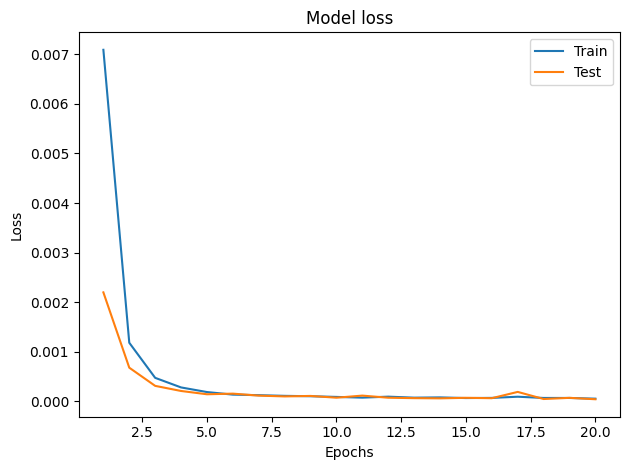

== Training Time ==
10.11 seconds

== Final loss ==
Train: 5.4521970014320686e-05
Test: 4.298001658753492e-05

== Mean absolute error ==
Train: 0.0049499320592603265
Test: 0.005138687457473017

== R2 Score ==
Train: 0.9983373846617722
Test: 0.9982004046440746



In [162]:
displayLearningCurve(history=history_3R, 
                    epochs=epochs_3R)

print(f"== Training Time ==\n{training_time:.2f} seconds\n")
print(f"== Final loss ==\nTrain: {history_3R.history['loss'][-1]}\nTest: {history_3R.history['val_loss'][-1]}\n")
print(f"== Mean absolute error ==\nTrain: {mae_3R_train}\nTest: {mae_3R_test}\n")
print(f"== R2 Score ==\nTrain: {r2_3R_train}\nTest: {r2_3R_test}\n")

### III - 3D with 5 joints

In [163]:
filepath_5R = r'data/5R_2184503_100.csv'
df_5R = pd.read_csv(filepath_5R, sep=";", header=0).copy()

display(df_5R.head(2))
df_5R.info()

,j0,j1,j2,j3,j4,cos(j0),cos(j1),cos(j2),cos(j3),cos(j4),...,sin(j2),sin(j3),sin(j4),ee_x,ee_y,ee_z,ee_qw,ee_qx,ee_qy,ee_qz
0,0.000,0.000,0.000,0.000,0.000,1.0,1.0,1.0,1.0,1.0,...,0.000,0.000,0.000,0.000,0.000,0.59,1.0,0.000,0.000,0.000
1,0.014,0.001,-0.001,0.031,-0.005,1.0,1.0,1.0,1.0,1.0,...,-0.001,0.031,-0.005,0.007,0.001,0.59,1.0,-0.003,0.016,0.007


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 22 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   j0        100000 non-null  float64
 1    j1       100000 non-null  float64
 2    j2       100000 non-null  float64
 3    j3       100000 non-null  float64
 4    j4       100000 non-null  float64
 5    cos(j0)  100000 non-null  float64
 6    cos(j1)  100000 non-null  float64
 7    cos(j2)  100000 non-null  float64
 8    cos(j3)  100000 non-null  float64
 9    cos(j4)  100000 non-null  float64
 10   sin(j0)  100000 non-null  float64
 11   sin(j1)  100000 non-null  float64
 12   sin(j2)  100000 non-null  float64
 13   sin(j3)  100000 non-null  float64
 14   sin(j4)  100000 non-null  float64
 15   ee_x     100000 non-null  float64
 16   ee_y     100000 non-null  float64
 17   ee_z     100000 non-null  float64
 18   ee_qw    100000 non-null  float64
 19   ee_qx    100000 non-null  float64
 20   ee_q

In [164]:
X_5R_raw = df_5R[['j0', ' j1', ' j2', ' j3', ' j4']].values
X_5R_raw = pd.DataFrame(X_5R_raw, columns=['j0', 'j1', 'j2', 'j3', 'j4'])
display(X_5R_raw.head(2))

,j0,j1,j2,j3,j4
0,0.000,0.000,0.000,0.000,0.000
1,0.014,0.001,-0.001,0.031,-0.005


In [165]:
y_5R_pos = df_5R[[' ee_x', ' ee_y', ' ee_z']].values
y_5R_ori = df_5R[[' ee_qw', ' ee_qx', ' ee_qy', ' ee_qz']].values
y_5R = pd.concat([pd.DataFrame(y_5R_pos, columns=['ee_x', 'ee_y', "ee_z"]), 
                         pd.DataFrame(y_5R_ori, columns=['ee_qw', 'ee_qx', 'ee_qy', 'ee_qz'])], axis=1)

display(y_5R.head(2))

,ee_x,ee_y,ee_z,ee_qw,ee_qx,ee_qy,ee_qz
0,0.000,0.000,0.59,1.0,0.000,0.000,0.000
1,0.007,0.001,0.59,1.0,-0.003,0.016,0.007


In [166]:
X_5R_train, X_5R_test, y_5R_train, y_5R_test = train_test_split(X_5R_raw, y_5R_pos, test_size=0.2, random_state=2184503)
print(X_5R_train.shape, y_5R_train.shape)
print(y_5R_test.shape, y_5R_test.shape)

(80000, 5) (80000, 3)
(20000, 3) (20000, 3)


In [167]:
percentage_5R = 0.75

subset_size_train = int(len(X_5R_train)*percentage_5R)
subset_size_test = int(len(X_5R_test)*percentage_5R)

X_5R_train = X_5R_train[:subset_size_train]
y_5R_train = y_5R_train[:subset_size_train]
X_5R_test = X_5R_test[:subset_size_test]
y_5R_test = y_5R_test[:subset_size_test]

print(X_5R_train.shape, y_5R_train.shape)
print(y_5R_test.shape, y_5R_test.shape)

(60000, 5) (60000, 3)
(15000, 3) (15000, 3)


In [168]:
model_5R = Sequential()
model_5R.add(Input((X_5R_train.shape[1],)))
model_5R.add(Dense(36, activation="relu"))  
model_5R.add(Dense(30, activation="relu")) 
model_5R.add(Dense(24, activation="relu")) 
model_5R.add(Dense(21, activation="relu"))  
model_5R.add(Dense(18, activation="relu")) 
model_5R.add(Dense(15, activation="relu"))  
model_5R.add(Dense(12, activation="relu")) 
model_5R.add(Dense(9, activation="relu"))  
model_5R.add(Dense(6, activation="relu"))   
model_5R.add(Dense(3, activation="relu"))
model_5R.add(Dense(y_5R_train.shape[1], activation="linear"))
model_5R.summary()

Model: "sequential_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_140 (Dense)               │ (None, 36)             │           216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_141 (Dense)               │ (None, 30)             │         1,110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_142 (Dense)               │ (None, 24)             │           744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_143 (Dense)               │ (None, 21)             │           525 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_144 (Dense)               │ (None, 18)             │           396 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_145 (Dense)               │ (None, 15)             │           285 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_146 (Dense)               │ (None, 12)             │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_147 (Dense)               │ (None, 9)              │           117 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_148 (Dense)               │ (None, 6)              │            60 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_149 (Dense)               │ (None, 3)              │            21 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_150 (Dense)               │ (None, 3)              │            12 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,678 (14.37 KB)

 Trainable params: 3,678 (14.37 KB)

 Non-trainable params: 0 (0.00 B)

In [169]:
model_5R.compile(loss=angular_loss, optimizer=Adam(learning_rate=0.001))

epochs_5R = 20
start = time.time()
history_5R = model_5R.fit(X_5R_train, y_5R_train,
                    epochs=epochs_5R,
                    validation_data=(X_5R_test, y_5R_test),
                    verbose=1)
training_time = time.time() - start


y_5R_train_pred = model_5R.predict(X_5R_train)
y_5R_test_pred = model_5R.predict(X_5R_test)

mae_5R_train = mean_absolute_error(y_5R_train, y_5R_train_pred)
mae_5R_test = mean_absolute_error(y_5R_test, y_5R_test_pred)

r2_5R_test = r2_score(y_5R_test, y_5R_test_pred)
r2_5R_train = r2_score(y_5R_train, y_5R_train_pred)

Epoch 1/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0116 - val_loss: 0.0011
Epoch 2/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 8.5156e-04 - val_loss: 5.2978e-04
Epoch 3/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 4.4141e-04 - val_loss: 3.3139e-04
Epoch 4/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 3.2966e-04 - val_loss: 3.5774e-04
Epoch 5/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 2.8372e-04 - val_loss: 2.4951e-04
Epoch 6/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 2.4211e-04 - val_loss: 2.2486e-04
Epoch 7/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 2.1854e-04 - val_loss: 1.7581e-04
Epoch 8/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 2.0228e-04 - val_loss: 2.4658e-04
Epoch 9/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 1.8994e-04 - val_loss: 1.8463e-04
Epoch 10/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 1.7387e-04 - val_loss: 1.9933e-04
Epoch 11/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2

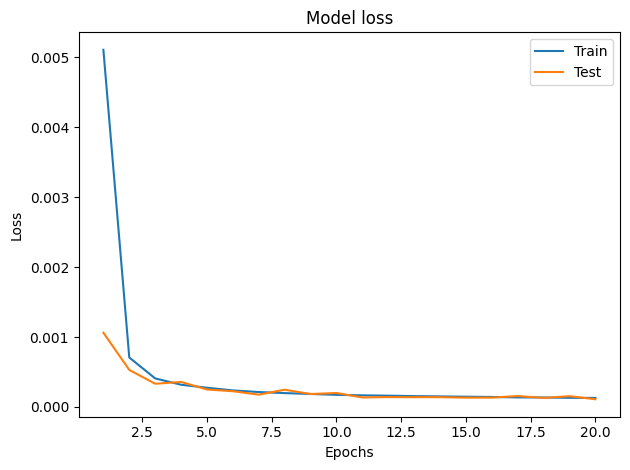

== Training Time ==
68.08 seconds

== Final loss ==
Train: 0.00012890362995676696
Test: 0.00010998200014000759

== Mean absolute error ==
Train: 0.008170248406539368
Test: 0.008273482578108051

== R2 Score ==
Train: 0.9964616119283273
Test: 0.9963246550360693


In [170]:
displayLearningCurve(history=history_5R, 
                    epochs=epochs_5R)

print(f"== Training Time ==\n{training_time:.2f} seconds\n")
print(f"== Final loss ==\nTrain: {history_5R.history['loss'][-1]}\nTest: {history_5R.history['val_loss'][-1]}\n")
print(f"== Mean absolute error ==\nTrain: {mae_5R_train}\nTest: {mae_5R_test}\n")
print(f"== R2 Score ==\nTrain: {r2_5R_train}\nTest: {r2_5R_test}")

##### Saving models

In [ ]:
# if not os.path.exists('models'):
#     os.makedirs('models')
    
# model_2R.save(filepath=f'models/NN4_2R_p{int(percentage_2R*100)}_e{epochs_2R}_raw.keras')
# model_3R.save(filepath=f'models/NN4_3R_p{int(percentage_3R*100)}_e{epochs_3R}_raw.keras')
# model_5R.save(filepath=f'models/NN4_5R_p{int(percentage_5R*100)}_e{epochs_5R}_raw.keras')

In [184]:
from tensorflow.keras.models import load_model
model_3R = load_model(r'C:\Workspace\Git_folders\Mujoco-ML\models\NN4_5R_p75_e20_raw.keras', custom_objects={'angular_loss': angular_loss})

In [185]:
y_3R_train_pred = model_3R.predict(X_5R_train)
y_3R_test_pred = model_3R.predict(X_5R_test)

mae_3R_train = mean_absolute_error(y_5R_train, y_3R_train_pred)
mae_3R_test = mean_absolute_error(y_5R_test, y_3R_test_pred)

r2_3R_test = r2_score(y_5R_test, y_3R_test_pred)
r2_3R_train = r2_score(y_5R_train, y_3R_train_pred)


print(f"== Mean absolute error ==\nTrain: {mae_3R_train}\nTest: {mae_3R_test}\n")
print(f"== R2 Score ==\nTrain: {r2_3R_train}\nTest: {r2_3R_test}\n")

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
== Mean absolute error ==
Train: 0.008170248406539368
Test: 0.008273482578108051

== R2 Score ==
Train: 0.9964616119283273
Test: 0.9963246550360693

